# Advanced Spatial Analysis
# Module 06: geopandas

- introduce the Python geospatial data science stack
- working with spatial data
- geometric operations
- projection
- mapping
- spatial joins
- spatial indexing

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy.distance import great_circle
from shapely.geometry import Point

%matplotlib inline

## 1. Quick overview of mapping and projection concepts

### Some terminology:

- **geoid**: (that's *gee-oid*) the surface of the earth's gravity field, which approximates mean sea level
- **spheroid** or **ellipsoid** (interchangeable terms): a model that smoothly approximates the geoid
- **datum**: based on spheroid but incorporates local variations in the shape of the Earth. Used to describe a point on the Earth's surface, such as in latitude and longitude.
  - NAD83 (North American Datum 1983) uses the GRS80 spheroid
  - WGS84 (World Geodetic Survey 1984 datum) uses the WGS84 spheroid
  - The latitude and longitude coordinates of some point differ slightly based on the datum. GPS uses WGS84.
- **coordinate reference system** (CRS) or spatial reference system (SRS): a series of parameters that [define](http://spatialreference.org/) the coordinate system and spatial extent (aka, domain) of some dataset.
- **geographic coordinate system** (GCS): specifies a datum, spheroid, units of measure (such as meters), and a prime meridian
- **projected coordinate system** or map projection: projects a map of the Earth's 3-D spherical surface onto a flat surface that can be measured in units like meters. Here's a [list of projections](https://en.wikipedia.org/wiki/List_of_map_projections).
- **eastings** and **northings**: the x and y coordinates of a projected map, usually measured in meters
- **false origin**: the 0,0 origin point from which eastings and northings are measured on the map, usually the lower left corner rather than the center
- **PROJ.4**: a library to convert/project spatial data with consistent CRS [parameter names](https://github.com/OSGeo/proj.4/wiki/GenParms)

### Common CRS parameters (and their PROJ.4 names):

- datum (datum)
- ellipse (ellps)
- projection (proj)
  - the name of the projected coordinate system, such as Albers Equal Area (aea) or Lambert Conformal Conic (lcc)
- standard parallels (lat_1, lat_2)
  - where the projection surface touches the globe - at the standard parallels, the projection shows no distortion
- central meridian and latitude of origin (lon_0, lat_0)
  - the origin of the projection's x and y coordinates (eastings and northings) - usually the center of the map projection
- false easting and false northing (x_0, y_0)
  - offsets to add to all your eastings and northings - usually used to make all the coordinates on the map positive numbers by starting 0,0 at the lower left corner rather than the center of the map (see false origin, above)

### Common projection types:

- *equal area* projections: maintain area at the expense of shape, distance, and direction - such as the [Albers Equal Area](https://en.wikipedia.org/wiki/Albers_projection) projection
- *conformal* projections: maintain shapes at the expense of area, distance, and direction - such as the [Lambert Conformal Conic](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection) projection
- *equidistant* projections: preserve distance from one point or along all meridians and parallels
- *azimuthal* projections: maintain direction from one point to all other points - such as an [orthographic](https://en.wikipedia.org/wiki/Orthographic_projection_in_cartography) projection
- others compromise to minimize overall distortion or aim for aesthetic value - such as the [Robinson](https://en.wikipedia.org/wiki/Robinson_projection) projection

## 2. Working with spatial data

We'll use [geopandas](http://geopandas.org/user.html), which spatializes pandas dataframes. 

In [2]:
# load usa point data as a regular pandas dataframe
df = pd.read_csv('data/usa-latlong.csv')

In [3]:
# convert it to a geopandas geodataframe
usa_points = gpd.GeoDataFrame(df)
usa_points.head()

,latitude,longitude
0,34.537094,-82.630303
1,35.025700,-78.970500
2,39.151817,-77.163810
3,38.636738,-121.319550
4,47.616955,-122.348921


In [4]:
# measure distance between the first two points in the dataset using geopy's great_circle function
# notice the points are represented as (lat, long) to do the distance calculation
point0 = usa_points.loc[0, 'latitude'], usa_points.loc[0, 'longitude']
point1 = usa_points.loc[1, 'latitude'], usa_points.loc[1, 'longitude']
great_circle(point0, point1).miles

210.40247096393645

In [5]:
# how far is each row from snell library?
def get_distance(row):
    snell_library = 42.338350, -71.088051
    distance = great_circle(snell_library, (row['latitude'], row['longitude'])).miles
    return round(distance, 2)

usa_points['miles_from_snell'] = usa_points.apply(get_distance, axis=1)
usa_points.head()

,latitude,longitude,miles_from_snell
0,34.537094,-82.630303,823.70
1,35.025700,-78.970500,659.70
2,39.151817,-77.163810,386.66
3,38.636738,-121.319550,2613.55
4,47.616955,-122.348921,2485.49


In [6]:
# load the states shapefile as a geodataframe
states = gpd.GeoDataFrame.from_file('data/states_21basic/states.shp')
len(states)

51

In [7]:
states.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,(POLYGON ((-160.0738033454681 22.0041773479577...
1,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...
2,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...
3,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...
4,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...


In [8]:
# what's in our shapefile?
states['STATE_NAME'].sort_values().unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [9]:
# or read in a geojson file
states2 = gpd.read_file('data/states.geojson')
states2.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,(POLYGON ((-160.0738033454681 22.0041773479577...
1,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...
2,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...
3,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...
4,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...


In [10]:
# you can edit your data then save the gdf to disk
states2['STATE_NAME'] = states2['STATE_NAME'].str.upper()
states2.to_file('data/states2')

C:\Anaconda\envs\ppua7237\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


## 2. Geometric operations

In [11]:
# create a geometry column in our point dataset to contain shapely geometry for geopandas to use
# notice the points are represented as long, lat so that they are equivalent to x, y
usa_points['geometry'] = usa_points.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
usa_points.head()

,latitude,longitude,miles_from_snell,geometry
0,34.537094,-82.630303,823.70,POINT (-82.630303 34.537094)
1,35.025700,-78.970500,659.70,POINT (-78.9705 35.0257)
2,39.151817,-77.163810,386.66,POINT (-77.16381 39.151817)
3,38.636738,-121.319550,2613.55,POINT (-121.31955 38.636738)
4,47.616955,-122.348921,2485.49,POINT (-122.348921 47.616955)


### 2.1. intersects

In [12]:
# get those states that intersect with the point data
# use geopandas unary_union attribute to get a single geometry object representing all the points
mask = states['geometry'].intersects(usa_points['geometry'].unary_union)
len(states[mask])

49

In [13]:
# which states didn't have any point data?
states[~mask]['STATE_NAME']

4    North Dakota
6         Wyoming
Name: STATE_NAME, dtype: object

### 2.2. within

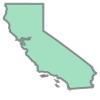

In [14]:
# get the geometry of the state with name california, as a geoseries of one element
california = states[states['STATE_NAME']=='California']['geometry']

# use iloc to extract the value from a geoseries of one element, to a shapely polygon
california_polygon = california.iloc[0]
california_polygon

In [15]:
# find all the points in CA
cal_points = usa_points[usa_points.within(california_polygon)]
len(cal_points)

161

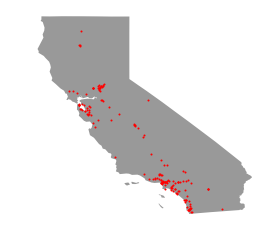

In [16]:
fig, ax = plt.subplots()
ax = california.plot(ax=ax, color='#999999')
ax = cal_points.plot(ax=ax, c='r', markersize=1)
ax.axis('off')
plt.show()

In [17]:
# another example: remove any point data that lies within Alaska or Hawaii
# first grab the polygons from these states' geoseries using iloc
alaska_polygon = states[states['STATE_NAME']=='Alaska']['geometry'].iloc[0]
hawaii_polygon = states[states['STATE_NAME']=='Hawaii']['geometry'].iloc[0]

# now use a mask to select all points *not* within either state's polygon
alaska_hawaii_mask = usa_points.within(alaska_polygon) | usa_points.within(hawaii_polygon)
contiguous_usa_points = usa_points[~alaska_hawaii_mask]
len(contiguous_usa_points)

998

### 2.3 dissolve to aggregate

In [18]:
mask = (states['STATE_NAME']!='Alaska') & (states['STATE_NAME']!='Hawaii')
contiguous_states = states[mask]

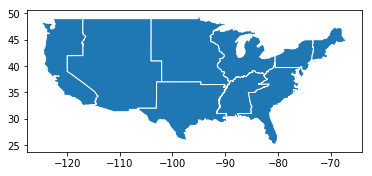

In [19]:
subregions = contiguous_states.dissolve('SUB_REGION')
ax = subregions.plot(linewidth=1, edgecolor='w')

### 2.4 convex hulls, envelopes, and centroids

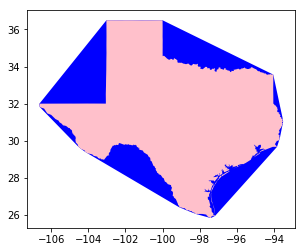

In [20]:
texas = states[states['STATE_NAME']=='Texas']
ax = texas.convex_hull.plot(color='b')
ax = texas.plot(ax=ax, color='pink')

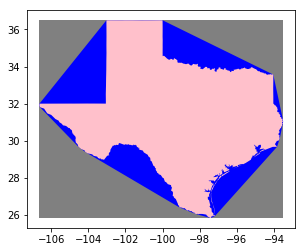

In [21]:
ax = texas.envelope.plot(color='gray')
ax = texas.convex_hull.plot(ax=ax, color='b')
ax = texas.plot(ax=ax, color='pink')

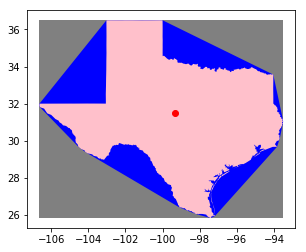

In [22]:
ax = texas.envelope.plot(color='gray')
ax = texas.convex_hull.plot(ax=ax, color='b')
ax = texas.plot(ax=ax, color='pink')
ax = texas.centroid.plot(ax=ax, color='r')

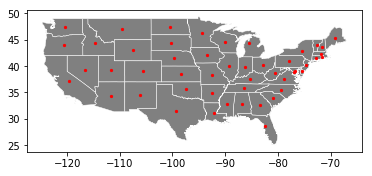

In [23]:
ax = contiguous_states.plot(color='gray', linewidth=0.5, edgecolor='w')
ax = contiguous_states.centroid.plot(ax=ax, color='r', markersize=5)

### 2.5. buffer, difference, and intersection

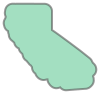

In [24]:
# you can easily calculate buffers
california_polygon.buffer(distance=1)

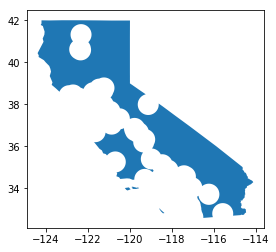

In [25]:
buffered_points = cal_points.buffer(0.5)
ax = california.difference(buffered_points.unary_union).plot()

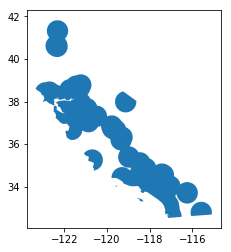

In [26]:
ax = california.intersection(buffered_points.unary_union).plot()

But these buffers are weird because the data is not projected. It's all in lat-long degrees. Let's project it.

## 3. Projection

Let's define a projection we can use to convert and map our lat-long data. The parameters in the following dictionaries correspond to the projection parameters from PROJ4. Geopandas uses the pyproj library to project spatial data, which in turn uses PROJ4 projection names and parameters.

You can figure out these parameter values either by approximating the lats and longs of your spatial data set, or by trial and error, or by looking up a reference like [this one](http://spatialreference.org/ref/epsg/26911/) for UTM zone 11. 

In [27]:
# you must specify the geodataframe's original CRS (if it doesn't already have one) so geopandas knows how to project it
# the GPS data is lat-long and its datum/ellipsoid is WGS84 - this is a geographic coordinate system
original_crs = {'init' : 'epsg:4326'}
cal_points.crs = original_crs
cal_points.crs

{'init': 'epsg:4326'}

In [28]:
california.crs

{'init': 'epsg:4269'}

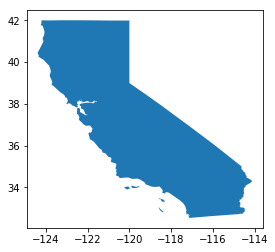

In [29]:
ax = california.plot()

In [30]:
# specify your projection manually
# we'll map with UTM zone 11 which is good for California - this is a projected coordinate system
utm_11 = '+proj=utm +zone=11 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'

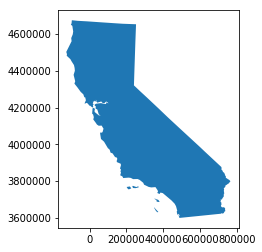

In [31]:
# the california shapefile already has an original CRS so we don't need to specify it - just project and plot it
california = california.to_crs(utm_11)
ax = california.plot()

**Be careful**: heed the difference between `gdf.crs` and `gdf.to_crs()`

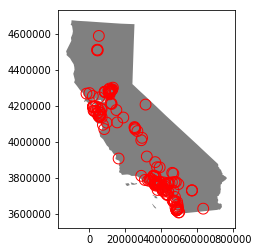

In [32]:
# now project the point data to the projected coordinate system, draw 20km buffers, and plot it
cal_points = cal_points.to_crs(utm_11)
ax = california.plot(color='gray')
ax = cal_points.buffer(30000).plot(ax=ax, color='none', edgecolor='r')

So that's our projected data and shapefile. Notice how the shape has changed, and how the units make more sense - they are in meters now. So our buffers are a 20km radius from each point.

Now let's project our entire USA points data to a projection appropriate for the entire USA. We'll specify the datum, ellipsoid, projection name, standard parallels, central meridian and latitude of origin, false easting and false northing (because matplotlib basemap sticks the origin at the lower left corner), and measurement units. 

In [33]:
# set our usa_points dataset's original CRS
usa_points.crs = original_crs
usa_points.head()

,latitude,longitude,miles_from_snell,geometry
0,34.537094,-82.630303,823.70,POINT (-82.630303 34.537094)
1,35.025700,-78.970500,659.70,POINT (-78.9705 35.0257)
2,39.151817,-77.163810,386.66,POINT (-77.16381 39.151817)
3,38.636738,-121.319550,2613.55,POINT (-121.31955 38.636738)
4,47.616955,-122.348921,2485.49,POINT (-122.348921 47.616955)


In [34]:
# specify the width and height of the map extent/domain in projection coordinate units (meters) - approx USA dimensions
map_width_m = 5000 * 1000 #5000 km
map_height_m = 3500 * 1000 #3500 km

In [35]:
# Albers Conical Equal Area projection for USA
albers_usa = {'datum':'NAD83',
              'ellps':'GRS80',
              'proj':'aea', 
              'lat_1':33, 
              'lat_2':45, 
              'lon_0':-97, 
              'lat_0':39, 
              'x_0':map_width_m/2, 
              'y_0':map_height_m/2,
              'units':'m'}

In [36]:
# now you can convert the point data to a projected CRS
# doesn't save the changes unless you do assignment
usa_points.to_crs(albers_usa).head()

,latitude,longitude,miles_from_snell,geometry
0,34.537094,-82.630303,823.70,POINT (3810700.428966676 1355670.344562951)
1,35.025700,-78.970500,659.70,POINT (4130004.501077835 1467971.140232016)
2,39.151817,-77.163810,386.66,POINT (4191992.744538555 1950989.928778355)
3,38.636738,-121.319550,2613.55,POINT (418673.136458593 1987565.730143214)
4,47.616955,-122.348921,2485.49,POINT (606046.7645739028 2972874.652640363)


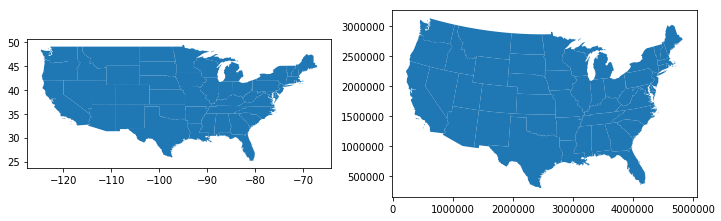

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 8))
ax1 = axes[0]
ax1 = contiguous_states.plot(ax=ax1)

ax2 = axes[1]
contiguous_states.to_crs(albers_usa).plot(ax=ax2)

plt.show()

Unprojected lat-long data (left) and projected data (right). The origin on the right is 0,0 like we'd expect for our false origin.

In [38]:
contiguous_states = contiguous_states.copy() #bc we sliced this from states gdf earlier
contiguous_states['area'] = contiguous_states.area
contiguous_states.sort_values('area', ascending=False).head()[['STATE_NAME', 'area']]

,STATE_NAME,area
40,Texas,65.059645
2,Montana,45.134303
24,California,41.533620
41,New Mexico,30.936646
22,Nevada,29.969924


In [39]:
contiguous_states_proj = contiguous_states.to_crs(albers_usa)
contiguous_states_proj['area'] = contiguous_states_proj.area / 1e9 # sq meters -> sq km
contiguous_states_proj.sort_values('area', ascending=False).head()[['STATE_NAME', 'area']]

,STATE_NAME,area
40,Texas,684.897807
24,California,408.642311
2,Montana,381.354659
41,New Mexico,315.352756
36,Arizona,294.512050


## 4. Mapping

C:\Anaconda\envs\ppua7237\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


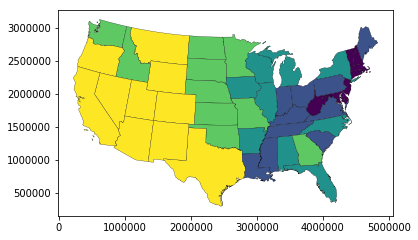

In [40]:
ax = contiguous_states_proj.plot(column='area', cmap='viridis', scheme='quantiles',
                                 edgecolor='k', linewidth=0.25)

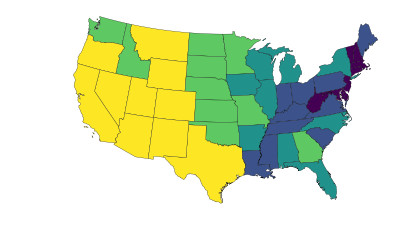

In [41]:
fig, ax = plt.subplots()
ax = contiguous_states_proj.plot(ax=ax, column='area', cmap='viridis', scheme='quantiles',
                                 edgecolor='k', linewidth=0.25)
ax.axis('off')
fig.savefig('data/map.png', dpi=600)
plt.show()

## 5. Spatial joins and spatial indexes

In [42]:
rents = pd.read_csv('data/listings.csv')
len(rents)

19483

In [43]:
rents = gpd.GeoDataFrame(rents)
rents['geometry'] = rents.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
rents.crs = original_crs
rents.head()

,bedrooms,rent,sqft,date,longitude,latitude,geometry
0,1.0,2900.0,NaN,2014-05-24,-73.974187,40.785946,POINT (-73.974187 40.785946)
1,2.0,850.0,NaN,2014-06-16,-124.084368,40.881354,POINT (-124.084368 40.88135399999999)
2,2.0,1020.0,1046.0,2014-06-08,-106.536400,31.838300,POINT (-106.5364 31.8383)
3,2.0,875.0,957.0,2014-06-11,-96.855898,33.007152,POINT (-96.855898 33.007152)
4,1.0,2299.0,NaN,2014-05-28,-73.961704,40.710904,POINT (-73.961704 40.710904)


In [44]:
rents.crs == contiguous_states.crs

False

In [45]:
rents = rents.to_crs(contiguous_states.crs)

In [46]:
rents_states = gpd.sjoin(rents, contiguous_states, how='left', op='within')

In [47]:
groups = rents_states.groupby('STATE_NAME')

In [48]:
# which states have the highest median rents?
groups['rent'].median().sort_values(ascending=False).head()

STATE_NAME
Massachusetts           2232.0
New York                2100.0
District of Columbia    1814.5
California              1500.0
Illinois                1395.0
Name: rent, dtype: float64

In [49]:
# which states have the most bedrooms/unit in the listings?
groups['bedrooms'].mean().sort_values(ascending=False).head()

STATE_NAME
Montana         2.560976
Wyoming         2.545455
Arkansas        2.543478
North Dakota    2.538462
Idaho           2.451220
Name: bedrooms, dtype: float64

### spatial indexing

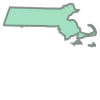

In [50]:
geometry = states[states['STATE_NAME']=='Massachusetts']['geometry'].iloc[0]
geometry

In [51]:
%%time
matches = rents.intersects(geometry)

Wall time: 127 ms


In [52]:
sindex = rents.sindex

In [53]:
%%time
possible_matches_index = list(sindex.intersection(geometry.bounds))
possible_matches = rents.iloc[possible_matches_index]
precise_matches = possible_matches[possible_matches.intersects(geometry)]

Wall time: 77 ms
